In [10]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath('..'))
from src.physics_engine import MarketSimulator  # 업데이트된 시뮬레이터 로드

# Heston vs Bates Model Comparison

이 노트북에서는 **Heston 모델**(확률적 변동성)과 **Bates 모델**(Heston + 점프 확산)의 차이를 시뮬레이션을 통해 비교합니다.

### 1. Heston Model
기초 자산의 주가와 그 변동성을 두 개의 상관된 확률 과정으로 모델링합니다.
$$ dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^S $$
$$ dv_t = \kappa(\theta - v_t)dt + \xi \sqrt{v_t} dW_t^v $$

### 2. Bates Model
Heston 모델에 Poisson Jump Process를 추가하여 주가의 급격한 변화(폭락 등)를 묘사합니다.
$$ dS_t = (\mu - \lambda \bar{k}) S_t dt + \sqrt{v_t} S_t dW_t^S + S_t dJ_t $$
어기서 $J_t$는 로그-정규 분포를 따르는 점프 크기를 가진 복합 포아송 과정입니다.

## 파라미터 설정 및 시뮬레이션 설정
Heston과 Bates 모델을 비교하기 위해 동일한 확산(Diffusion) 파라미터를 사용합니다.

In [11]:
# 기본 파라미터
S0 = 100.0
v0 = 0.04
T = 1.0
dt = 1/252  # 1일
num_paths = 100000

# Heston/Bates 파라미터
params = {
    'mu': 0.0,
    'kappa': 3.0,
    'theta': 0.04,
    'xi': 0.6,
    'rho': -0.7,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Bates 전용 (점프) 파라미터
jump_params = {
    'jump_lambda': 1.0,   # 연간 평균 1회 점프
    'jump_mean': -0.15,   # 점프 시 평균 -15% 하락
    'jump_std': 0.1       # 점프 크기의 변동성
}

print(f"Using device: {params['device']}")

Using device: cuda


## 1. Heston 시뮬레이션

In [12]:
heston_sim = MarketSimulator(**params)
S_heston, v_heston = heston_sim.simulate(S0, v0, T, dt, num_paths, model_type='heston')

print("Heston simulation completed.")

Heston simulation completed.


## 2. Bates 시뮬레이션

In [13]:
bates_sim = MarketSimulator(**params, **jump_params)
S_bates, v_bates = bates_sim.simulate(S0, v0, T, dt, num_paths, model_type='bates')

print("Bates simulation completed.")

Bates simulation completed.


## 결과 비교 시각화

### 경로(Paths) 비교

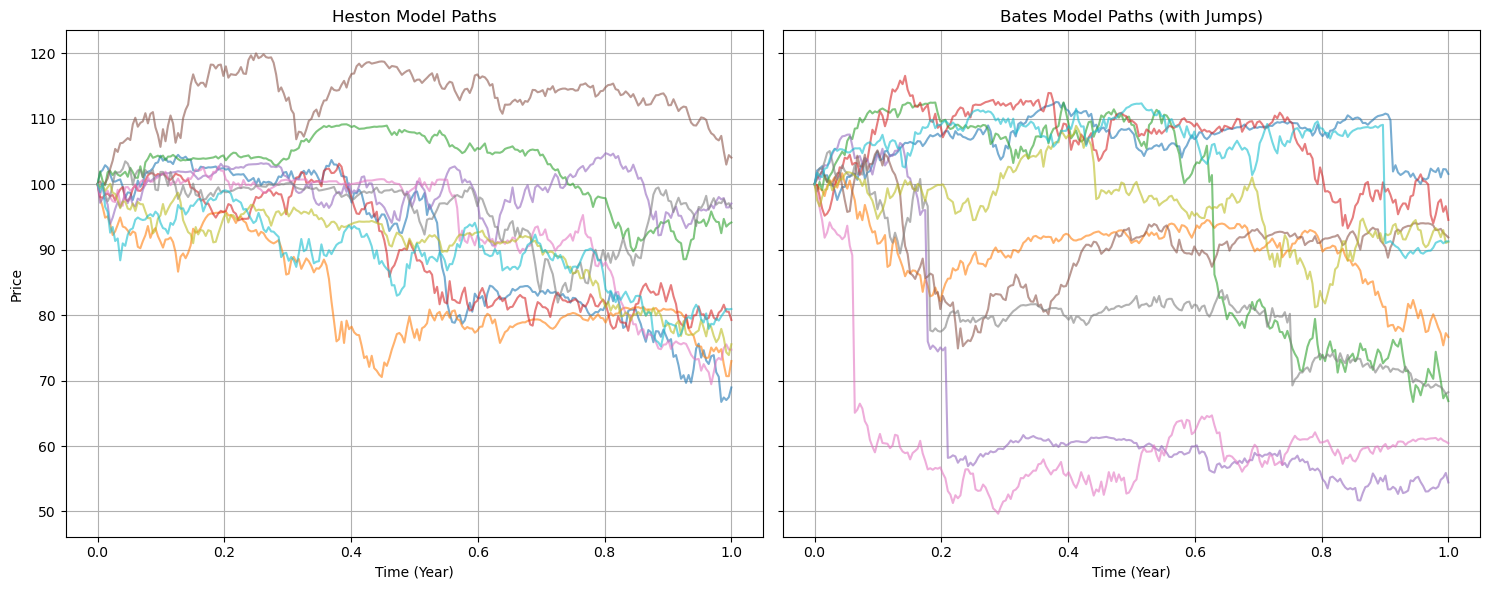

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# CPU로 데이터 이동
S_h_cpu = S_heston.cpu().numpy()
S_b_cpu = S_bates.cpu().numpy()
steps = S_h_cpu.shape[1]
time_axis = np.linspace(0, T, steps)

# Heston Plot
for i in range(min(10, num_paths)):
    axes[0].plot(time_axis, S_h_cpu[i], alpha=0.6)
axes[0].set_title("Heston Model Paths")
axes[0].set_xlabel("Time (Year)")
axes[0].set_ylabel("Price")
axes[0].grid(True)

# Bates Plot
for i in range(min(10, num_paths)):
    axes[1].plot(time_axis, S_b_cpu[i], alpha=0.6)
axes[1].set_title("Bates Model Paths (with Jumps)")
axes[1].set_xlabel("Time (Year)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 기초 자산 수익률 분포(Log Returns Distribution) 비교
Bates 모델은 점프로 인해 수익률 분포의 꼬리가 더 두꺼워지는(Fat Tails) 현상을 보입니다.

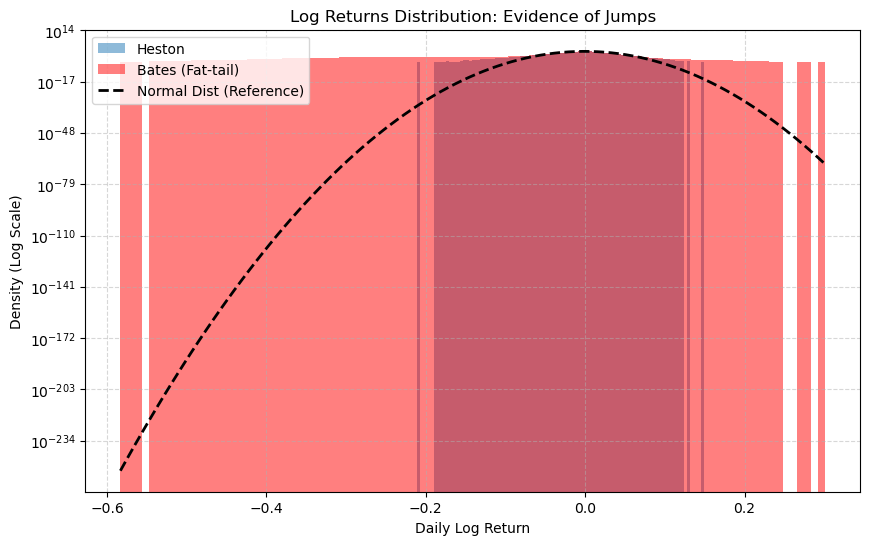

In [15]:
from scipy.stats import norm

returns_h = np.diff(np.log(S_h_cpu), axis=1).flatten()
returns_b = np.diff(np.log(S_b_cpu), axis=1).flatten()

plt.figure(figsize=(10, 6))

# 히스토그램
plt.hist(returns_h, bins=100, alpha=0.5, label='Heston', density=True)
plt.hist(returns_b, bins=100, alpha=0.5, label='Bates (Fat-tail)', density=True, color='red')

# 비교용 정규분포 곡선 (Bates의 평균과 표준편차 사용)
mu_b, std_b = norm.fit(returns_b)
x = np.linspace(min(returns_b), max(returns_b), 100)
p = norm.pdf(x, mu_b, std_b)
plt.plot(x, p, 'k--', linewidth=2, label='Normal Dist (Reference)')

plt.yscale('log') # 로그 스케일 필수!
plt.title("Log Returns Distribution: Evidence of Jumps")
plt.xlabel("Daily Log Return")
plt.ylabel("Density (Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

### Volatility Smile/Skew 비교
이 섹션에서는 Monte Carlo 시뮬레이션을 통해 얻은 옵션 가격을 바탕으로 **Implied Volatility (내재 변동성)**를 역산하여, 두 모델이 그리는 Volatility Smile의 차이를 확인합니다.

[Bias Check] Heston Mean: 81.23 -> Corrected to 100.0
[Bias Check] Bates Mean:  81.18 -> Corrected to 100.0
Calculating Implied Volatilities (with Correction)...


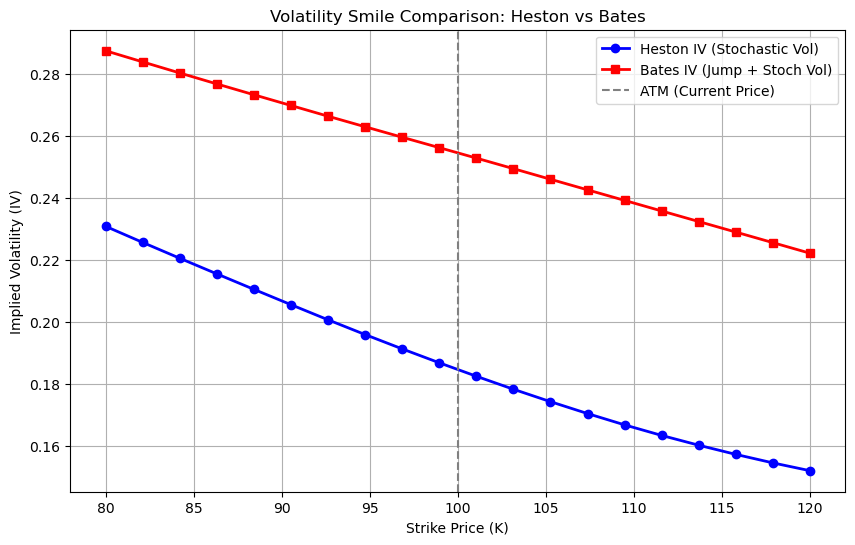

In [16]:
from scipy.stats import norm
from scipy.optimize import brentq

# 1. 블랙-숄즈 내재 변동성(IV) 역산 함수
def implied_volatility(price, S, K, T, r, option_type='call'):
    """
    시장 가격(price)을 주면, 그 가격이 나오기 위한 변동성(sigma)을 역산해줍니다.
    """
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    # 이분법(Bisection method)으로 오차 0이 되는 sigma 찾기
    try:
        return brentq(lambda x: bs_price(x) - price, 1e-6, 5.0)
    except:
        return np.nan

# 2. 행사가격별 옵션 가격 및 IV 계산
# --- Martingale Correction (평균 보정) 적용 ---
# 시뮬레이션의 평균이 100에서 벗어나는 오차를 잡아줍니다.
h_mean = S_h_cpu[:, -1].mean()
b_mean = S_b_cpu[:, -1].mean()

# 보정 계수 (Target 100 / Actual Mean)
h_corr = S0 / h_mean
b_corr = S0 / b_mean

print(f"[Bias Check] Heston Mean: {h_mean:.2f} -> Corrected to 100.0")
print(f"[Bias Check] Bates Mean:  {b_mean:.2f} -> Corrected to 100.0")

iv_heston = []
iv_bates = []

print("Calculating Implied Volatilities (with Correction)...")

for K_val in K_range:
    # A. Heston Model Price (보정된 주가 사용)
    # S_T에 보정 계수(h_corr)를 곱해서 평균을 100으로 맞춤
    payoff_h = np.maximum(S_h_cpu[:, -1] * h_corr - K_val, 0)
    price_h = np.mean(payoff_h) * np.exp(-r * T)
    
    # B. Bates Model Price (보정된 주가 사용)
    payoff_b = np.maximum(S_b_cpu[:, -1] * b_corr - K_val, 0)
    price_b = np.mean(payoff_b) * np.exp(-r * T)
    
    # IV 역산
    iv_h = implied_volatility(price_h, S0, K_val, T, r)
    iv_b = implied_volatility(price_b, S0, K_val, T, r)
    
    iv_heston.append(iv_h)
    iv_bates.append(iv_b)


# 3. 결과 시각화: 이것이 'Volatility Smile' 입니다
plt.figure(figsize=(10, 6))

plt.plot(K_range, iv_heston, 'b-o', label='Heston IV (Stochastic Vol)', linewidth=2)
plt.plot(K_range, iv_bates, 'r-s', label='Bates IV (Jump + Stoch Vol)', linewidth=2)

plt.axvline(S0, color='gray', linestyle='--', label='ATM (Current Price)')
plt.title("Volatility Smile Comparison: Heston vs Bates")
plt.xlabel("Strike Price (K)")
plt.ylabel("Implied Volatility (IV)")
plt.legend()
plt.grid(True)
plt.show()